<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/optuna_and_bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 8th July, 2021
# Myfolder: C:\Users\Administrator\OneDrive\Documents\breast_cancer
#
# Ref: https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
#      https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_simple.py
#
# Objective:
#           i) Learn to use automated tuning of lightgbm
#          ii) Using optuna
#         iii) Perform Bayesian optimization
#
# See also 'h2o_talkingData.ipynb' in folder:
#   C:\Users\Administrator\OneDrive\Documents\talkingdata

In [ ]:
"""
Optuna example that optimizes a classifier configuration
for cancer dataset using LightGBM tuner.
In this example, we optimize the validation log loss of
cancer detection.

"""

### Install libraries

In [18]:
# Downgrade sklearn
# Higher version gives problem with BayesSearchCV
conda install -c intel scikit-learn==0.23.2
! pip install scikit-learn==0.23.2 
import sklearn
sklearn.__version__

'0.23.2'

In [19]:
# 0.0 Optuna
#     https://optuna.org/
! pip install optuna

In [20]:
# 0.1 sklearn optimizer
# 
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'

In [21]:
# 0.2 Lightgbm
! pip install lightgbm --upgrade
import lightgbm
lightgbm.__version__

Requirement already up-to-date: lightgbm in /usr/local/lib/python3.7/dist-packages (3.2.1)


'3.2.1'

In [22]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1.1 Import optuna integration with lightgbm
# Install as: conda install -c conda-forge optuna

import optuna.integration.lightgbm as lgbm


# 1.2  Return stratified folds. The folds are made by
#      preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

# 1.3 ML - we will classify using lightgbm
#          with stratified cross validation
#      conda install -c conda-forge lightgbm 
import lightgbm as lgb

# 1.4 OS related
import os, time

# 1.5 Bayes optimization--IInd method
# SKOPT is a parameter-optimisation framewor
#  Install skopt as:
#     conda install -c conda-forge scikit-optimize


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
# 1.6
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [24]:
# # 2.0 Get data and split it
data,target = make_classification( n_samples = 10000,
                          n_features = 20,
                          n_informative = 10,
                          n_redundant = 2,
                          n_repeated = 3,
                          n_classes = 2,
                          flip_y = 0.01,
                          shuffle = True)

# 2.0.1
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)

In [25]:
# 2.1 Transform train_x and val_x to lightgbm data-matricies

dtrain = lgbm.Dataset(train_x, label=train_y)

dval = lgbm.Dataset(val_x, label=val_y)

In [26]:
# 3.0 Set fixed hyper-params
params_fixed = {                           # Specify params that are fixed
                 "objective": "binary",
                 "metric": "binary_logloss",
                 "verbosity": -1,
                 "boosting_type": "gbdt",
                }

In [27]:
# 3.1 Note that unlike in sklearn, here there is
#     no instantiation of LightGBM model
#     Start modeling as also tuning hyperparameters

model = lgbm.train(
                   params_fixed,               # Just fixed params only
                   dtrain,                     # Dataset
                   valid_sets=[dtrain, dval],  # Evaluate performance on these datasets
                   verbose_eval=100,
                   early_stopping_rounds=100,
                   #categorical_features = ["c0", "c7"]
                  )


[I 2021-07-08 11:55:06,956] A new study created in memory with name: no-name-1a97cfd3-56db-485e-a56c-a44d9f238677
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0568924	valid_1's binary_logloss: 0.170773
[200]	valid_0's binary_logloss: 0.0169738	valid_1's binary_logloss: 0.170037


feature_fraction, val_score: 0.168536:  14%|#4        | 1/7 [00:01<00:07,  1.25s/it]

Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.0280817	valid_1's binary_logloss: 0.168536
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0530946	valid_1's binary_logloss: 0.16755
[200]	valid_0's binary_logloss: 0.0153786	valid_1's binary_logloss: 0.168119


feature_fraction, val_score: 0.164654:  29%|##8       | 2/7 [00:02<00:06,  1.27s/it]

Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.0334067	valid_1's binary_logloss: 0.164654
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0545368	valid_1's binary_logloss: 0.168682


feature_fraction, val_score: 0.164654:  43%|####2     | 3/7 [00:03<00:04,  1.21s/it]

[200]	valid_0's binary_logloss: 0.0157384	valid_1's binary_logloss: 0.172265
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.0472145	valid_1's binary_logloss: 0.16783
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0636866	valid_1's binary_logloss: 0.175667
[200]	valid_0's binary_logloss: 0.0192202	valid_1's binary_logloss: 0.170951


feature_fraction, val_score: 0.164654:  57%|#####7    | 4/7 [00:04<00:03,  1.20s/it]

Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.0203034	valid_1's binary_logloss: 0.170182
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0689838	valid_1's binary_logloss: 0.174017
[200]	valid_0's binary_logloss: 0.0223302	valid_1's binary_logloss: 0.172254
Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.0354445	valid_1's binary_logloss: 0.170544


feature_fraction, val_score: 0.164654:  71%|#######1  | 5/7 [00:05<00:02,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0579577	valid_1's binary_logloss: 0.171431
[200]	valid_0's binary_logloss: 0.0176041	valid_1's binary_logloss: 0.168904


feature_fraction, val_score: 0.164654:  86%|########5 | 6/7 [00:06<00:01,  1.15s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.0269221	valid_1's binary_logloss: 0.16658
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0779442	valid_1's binary_logloss: 0.178162
[200]	valid_0's binary_logloss: 0.0261468	valid_1's binary_logloss: 0.173023


num_leaves, val_score: 0.164654:   0%|          | 0/20 [00:00<?, ?it/s]

[300]	valid_0's binary_logloss: 0.00977079	valid_1's binary_logloss: 0.182603
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.0235545	valid_1's binary_logloss: 0.17197
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00440891	valid_1's binary_logloss: 0.178052


num_leaves, val_score: 0.164654:   5%|5         | 1/20 [00:02<00:38,  2.03s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.0181216	valid_1's binary_logloss: 0.170219
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00271529	valid_1's binary_logloss: 0.187876


num_leaves, val_score: 0.164654:  10%|#         | 2/20 [00:04<00:37,  2.08s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0265069	valid_1's binary_logloss: 0.170969
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00164462	valid_1's binary_logloss: 0.205119


num_leaves, val_score: 0.164654:  15%|#5        | 3/20 [00:07<00:41,  2.44s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.0189414	valid_1's binary_logloss: 0.174338
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0107728	valid_1's binary_logloss: 0.172687


num_leaves, val_score: 0.164654:  20%|##        | 4/20 [00:09<00:35,  2.23s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.019578	valid_1's binary_logloss: 0.168596
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0120522	valid_1's binary_logloss: 0.169418


num_leaves, val_score: 0.164654:  25%|##5       | 5/20 [00:10<00:30,  2.06s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.0301225	valid_1's binary_logloss: 0.16705
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00237127	valid_1's binary_logloss: 0.196503


num_leaves, val_score: 0.164654:  30%|###       | 6/20 [00:13<00:29,  2.11s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.0262541	valid_1's binary_logloss: 0.17563
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00977201	valid_1's binary_logloss: 0.168525


num_leaves, val_score: 0.164654:  35%|###5      | 7/20 [00:14<00:26,  2.01s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.018645	valid_1's binary_logloss: 0.164898
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0158799	valid_1's binary_logloss: 0.169574


num_leaves, val_score: 0.164654:  40%|####      | 8/20 [00:16<00:22,  1.88s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0219059	valid_1's binary_logloss: 0.16596
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00523154	valid_1's binary_logloss: 0.183572


num_leaves, val_score: 0.164654:  45%|####5     | 9/20 [00:18<00:20,  1.91s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.0249668	valid_1's binary_logloss: 0.171041
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00180459	valid_1's binary_logloss: 0.197418


num_leaves, val_score: 0.164654:  50%|#####     | 10/20 [00:20<00:20,  2.09s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.02446	valid_1's binary_logloss: 0.170108
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0016395	valid_1's binary_logloss: 0.199118


num_leaves, val_score: 0.164654:  55%|#####5    | 11/20 [00:24<00:21,  2.38s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.0168625	valid_1's binary_logloss: 0.173813
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.181875	valid_1's binary_logloss: 0.224683
[200]	valid_0's binary_logloss: 0.132381	valid_1's binary_logloss: 0.196342
[300]	valid_0's binary_logloss: 0.102514	valid_1's binary_logloss: 0.185436
[400]	valid_0's binary_logloss: 0.079901	valid_1's binary_logloss: 0.177778
[500]	valid_0's binary_logloss: 0.0623771	valid_1's binary_logloss: 0.173702
[600]	valid_0's binary_logloss: 0.0502206	valid_1's binary_logloss: 0.17239
[700]	valid_0's binary_logloss: 0.0399868	valid_1's binary_logloss: 0.16994


num_leaves, val_score: 0.164654:  60%|######    | 12/20 [00:25<00:17,  2.20s/it]

[800]	valid_0's binary_logloss: 0.0321168	valid_1's binary_logloss: 0.169963
Early stopping, best iteration is:
[733]	valid_0's binary_logloss: 0.0368297	valid_1's binary_logloss: 0.168891
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.138974	valid_1's binary_logloss: 0.197238
[200]	valid_0's binary_logloss: 0.0891179	valid_1's binary_logloss: 0.179676
[300]	valid_0's binary_logloss: 0.0596496	valid_1's binary_logloss: 0.17295
[400]	valid_0's binary_logloss: 0.0408285	valid_1's binary_logloss: 0.171751
Early stopping, best iteration is:
[375]	valid_0's binary_logloss: 0.0451601	valid_1's binary_logloss: 0.170579


num_leaves, val_score: 0.164654:  65%|######5   | 13/20 [00:27<00:13,  1.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0356521	valid_1's binary_logloss: 0.17087


num_leaves, val_score: 0.164654:  70%|#######   | 14/20 [00:28<00:10,  1.80s/it]

[200]	valid_0's binary_logloss: 0.00690575	valid_1's binary_logloss: 0.176263
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0221743	valid_1's binary_logloss: 0.169056


[I 2021-07-08 11:55:43,617] Trial 20 finished with value: 0.16905626434109725 and parameters: {'num_leaves': 40}. Best is trial 13 with value: 0.16489803585414917.
num_leaves, val_score: 0.164654:  70%|#######   | 14/20 [00:28<00:10,  1.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0281131	valid_1's binary_logloss: 0.168271


num_leaves, val_score: 0.164654:  75%|#######5  | 15/20 [00:29<00:08,  1.66s/it]

Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0319322	valid_1's binary_logloss: 0.167379
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.019287	valid_1's binary_logloss: 0.166953


num_leaves, val_score: 0.164654:  80%|########  | 16/20 [00:31<00:06,  1.61s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0259429	valid_1's binary_logloss: 0.166153
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0881637	valid_1's binary_logloss: 0.175905
[200]	valid_0's binary_logloss: 0.0392835	valid_1's binary_logloss: 0.166431


num_leaves, val_score: 0.164654:  85%|########5 | 17/20 [00:32<00:04,  1.45s/it]

Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.047704	valid_1's binary_logloss: 0.165453
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.104379	valid_1's binary_logloss: 0.181778
[200]	valid_0's binary_logloss: 0.054238	valid_1's binary_logloss: 0.174025
[300]	valid_0's binary_logloss: 0.0285448	valid_1's binary_logloss: 0.170955


num_leaves, val_score: 0.164654:  90%|######### | 18/20 [00:33<00:02,  1.45s/it]

[400]	valid_0's binary_logloss: 0.0148546	valid_1's binary_logloss: 0.171163
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.0238361	valid_1's binary_logloss: 0.169047
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00690887	valid_1's binary_logloss: 0.178476


num_leaves, val_score: 0.164654:  95%|#########5| 19/20 [00:35<00:01,  1.57s/it]

Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0204649	valid_1's binary_logloss: 0.168969
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0416161	valid_1's binary_logloss: 0.167318


bagging, val_score: 0.164654:   0%|          | 0/10 [00:00<?, ?it/s]

[200]	valid_0's binary_logloss: 0.00962081	valid_1's binary_logloss: 0.173849
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.0373751	valid_1's binary_logloss: 0.166181
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0514038	valid_1's binary_logloss: 0.169617


bagging, val_score: 0.164654:  10%|#         | 1/10 [00:01<00:10,  1.14s/it]

[200]	valid_0's binary_logloss: 0.0135067	valid_1's binary_logloss: 0.177292
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.0468626	valid_1's binary_logloss: 0.168858
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0561597	valid_1's binary_logloss: 0.170697
[200]	valid_0's binary_logloss: 0.0154832	valid_1's binary_logloss: 0.171458
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.0352891	valid_1's binary_logloss: 0.166508


bagging, val_score: 0.164654:  20%|##        | 2/10 [00:02<00:09,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0508023	valid_1's binary_logloss: 0.168022
[200]	valid_0's binary_logloss: 0.0135763	valid_1's binary_logloss: 0.17221
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.0315551	valid_1's binary_logloss: 0.167382


bagging, val_score: 0.164654:  30%|###       | 3/10 [00:03<00:08,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0526517	valid_1's binary_logloss: 0.172654


bagging, val_score: 0.164654:  40%|####      | 4/10 [00:05<00:07,  1.25s/it]

[200]	valid_0's binary_logloss: 0.015211	valid_1's binary_logloss: 0.173754
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0400874	valid_1's binary_logloss: 0.169829
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0531485	valid_1's binary_logloss: 0.17349


bagging, val_score: 0.164654:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]

[200]	valid_0's binary_logloss: 0.0143836	valid_1's binary_logloss: 0.174855
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0468871	valid_1's binary_logloss: 0.172689
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0541996	valid_1's binary_logloss: 0.172897


bagging, val_score: 0.164654:  60%|######    | 6/10 [00:07<00:04,  1.21s/it]

[200]	valid_0's binary_logloss: 0.0150669	valid_1's binary_logloss: 0.182116
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.05358	valid_1's binary_logloss: 0.17281
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0524263	valid_1's binary_logloss: 0.172315
[200]	valid_0's binary_logloss: 0.0148849	valid_1's binary_logloss: 0.174196


bagging, val_score: 0.164654:  70%|#######   | 7/10 [00:08<00:03,  1.30s/it]

Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.0239036	valid_1's binary_logloss: 0.170655
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0578373	valid_1's binary_logloss: 0.17934
[200]	valid_0's binary_logloss: 0.0163762	valid_1's binary_logloss: 0.178378


bagging, val_score: 0.164654:  80%|########  | 8/10 [00:10<00:02,  1.34s/it]

Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.0272428	valid_1's binary_logloss: 0.173958
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519917	valid_1's binary_logloss: 0.164734
[200]	valid_0's binary_logloss: 0.0133435	valid_1's binary_logloss: 0.167695


bagging, val_score: 0.162487:  90%|######### | 9/10 [00:11<00:01,  1.41s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.0206616	valid_1's binary_logloss: 0.162487
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0507708	valid_1's binary_logloss: 0.170318


feature_fraction_stage2, val_score: 0.162487:   0%|          | 0/3 [00:00<?, ?it/s]

[200]	valid_0's binary_logloss: 0.0133893	valid_1's binary_logloss: 0.174087
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.0416798	valid_1's binary_logloss: 0.167752
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0522151	valid_1's binary_logloss: 0.169609


feature_fraction_stage2, val_score: 0.162487:  33%|###3      | 1/3 [00:01<00:02,  1.27s/it]

[200]	valid_0's binary_logloss: 0.0140353	valid_1's binary_logloss: 0.17247
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.0386372	valid_1's binary_logloss: 0.167994
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0540345	valid_1's binary_logloss: 0.169068
[200]	valid_0's binary_logloss: 0.0146455	valid_1's binary_logloss: 0.169742


feature_fraction_stage2, val_score: 0.162487:  67%|######6   | 2/3 [00:02<00:01,  1.32s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.0228551	valid_1's binary_logloss: 0.165011
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519917	valid_1's binary_logloss: 0.164734
[200]	valid_0's binary_logloss: 0.0133435	valid_1's binary_logloss: 0.167695


regularization_factors, val_score: 0.162487:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.0206616	valid_1's binary_logloss: 0.162487
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0752738	valid_1's binary_logloss: 0.16932
[200]	valid_0's binary_logloss: 0.036102	valid_1's binary_logloss: 0.166039


regularization_factors, val_score: 0.162487:   5%|5         | 1/20 [00:01<00:32,  1.73s/it]

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.0434335	valid_1's binary_logloss: 0.163865
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0523182	valid_1's binary_logloss: 0.168885
[200]	valid_0's binary_logloss: 0.0140262	valid_1's binary_logloss: 0.168312


regularization_factors, val_score: 0.162487:  10%|#         | 2/20 [00:03<00:31,  1.73s/it]

Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.0224559	valid_1's binary_logloss: 0.163907
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0522029	valid_1's binary_logloss: 0.167841
[200]	valid_0's binary_logloss: 0.01337	valid_1's binary_logloss: 0.165364


regularization_factors, val_score: 0.162180:  15%|#5        | 3/20 [00:05<00:29,  1.73s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.0216304	valid_1's binary_logloss: 0.16218
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519919	valid_1's binary_logloss: 0.164734
[200]	valid_0's binary_logloss: 0.0133438	valid_1's binary_logloss: 0.167695


regularization_factors, val_score: 0.162180:  20%|##        | 4/20 [00:06<00:27,  1.73s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.0206619	valid_1's binary_logloss: 0.162487
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.05591	valid_1's binary_logloss: 0.169752
[200]	valid_0's binary_logloss: 0.0198294	valid_1's binary_logloss: 0.168605


regularization_factors, val_score: 0.162180:  25%|##5       | 5/20 [00:08<00:26,  1.75s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.026808	valid_1's binary_logloss: 0.165509
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519919	valid_1's binary_logloss: 0.164734
[200]	valid_0's binary_logloss: 0.0133437	valid_1's binary_logloss: 0.167695


regularization_factors, val_score: 0.162180:  30%|###       | 6/20 [00:10<00:24,  1.75s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.0206618	valid_1's binary_logloss: 0.162487
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0528162	valid_1's binary_logloss: 0.174159
[200]	valid_0's binary_logloss: 0.0145546	valid_1's binary_logloss: 0.173566


regularization_factors, val_score: 0.162180:  35%|###5      | 7/20 [00:12<00:22,  1.75s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.0226935	valid_1's binary_logloss: 0.171856
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0521136	valid_1's binary_logloss: 0.168345
[200]	valid_0's binary_logloss: 0.0135753	valid_1's binary_logloss: 0.171267
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.0343514	valid_1's binary_logloss: 0.165518


regularization_factors, val_score: 0.162180:  40%|####      | 8/20 [00:13<00:20,  1.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0521151	valid_1's binary_logloss: 0.168346
[200]	valid_0's binary_logloss: 0.0138772	valid_1's binary_logloss: 0.170569
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.0343531	valid_1's binary_logloss: 0.165517


regularization_factors, val_score: 0.162180:  45%|####5     | 9/20 [00:15<00:17,  1.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0537758	valid_1's binary_logloss: 0.171205
[200]	valid_0's binary_logloss: 0.0167683	valid_1's binary_logloss: 0.172118


regularization_factors, val_score: 0.162180:  50%|#####     | 10/20 [00:17<00:16,  1.67s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.0244653	valid_1's binary_logloss: 0.168632
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0524526	valid_1's binary_logloss: 0.169324
[200]	valid_0's binary_logloss: 0.0139005	valid_1's binary_logloss: 0.169041


regularization_factors, val_score: 0.162180:  55%|#####5    | 11/20 [00:18<00:15,  1.70s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.0216596	valid_1's binary_logloss: 0.164661
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519917	valid_1's binary_logloss: 0.164734
[200]	valid_0's binary_logloss: 0.0133435	valid_1's binary_logloss: 0.167695


regularization_factors, val_score: 0.162180:  60%|######    | 12/20 [00:20<00:13,  1.71s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.0206617	valid_1's binary_logloss: 0.162487
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519926	valid_1's binary_logloss: 0.164734


regularization_factors, val_score: 0.162180:  65%|######5   | 13/20 [00:21<00:11,  1.63s/it]

[200]	valid_0's binary_logloss: 0.0135027	valid_1's binary_logloss: 0.167677
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.041084	valid_1's binary_logloss: 0.16269
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519917	valid_1's binary_logloss: 0.164734
[200]	valid_0's binary_logloss: 0.0133435	valid_1's binary_logloss: 0.167695


regularization_factors, val_score: 0.162180:  70%|#######   | 14/20 [00:23<00:09,  1.66s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.0206616	valid_1's binary_logloss: 0.162487
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0524463	valid_1's binary_logloss: 0.169324
[200]	valid_0's binary_logloss: 0.0136494	valid_1's binary_logloss: 0.170838


regularization_factors, val_score: 0.162180:  75%|#######5  | 15/20 [00:25<00:08,  1.70s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.021182	valid_1's binary_logloss: 0.16658
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0519927	valid_1's binary_logloss: 0.164734


regularization_factors, val_score: 0.162180:  80%|########  | 16/20 [00:26<00:06,  1.62s/it]

[200]	valid_0's binary_logloss: 0.0135027	valid_1's binary_logloss: 0.167677
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0410841	valid_1's binary_logloss: 0.16269
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0721489	valid_1's binary_logloss: 0.169499
[200]	valid_0's binary_logloss: 0.029415	valid_1's binary_logloss: 0.16038


regularization_factors, val_score: 0.159145:  85%|########5 | 17/20 [00:28<00:05,  1.73s/it]

Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.0313319	valid_1's binary_logloss: 0.159145
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0906454	valid_1's binary_logloss: 0.173771
[200]	valid_0's binary_logloss: 0.0464445	valid_1's binary_logloss: 0.166846
[300]	valid_0's binary_logloss: 0.0278089	valid_1's binary_logloss: 0.167081


regularization_factors, val_score: 0.159145:  90%|######### | 18/20 [00:31<00:03,  1.97s/it]

Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.0307365	valid_1's binary_logloss: 0.166041
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0593806	valid_1's binary_logloss: 0.170316
[200]	valid_0's binary_logloss: 0.0199784	valid_1's binary_logloss: 0.167201


regularization_factors, val_score: 0.159145:  95%|#########5| 19/20 [00:33<00:01,  1.92s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.0291046	valid_1's binary_logloss: 0.164907
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.054639	valid_1's binary_logloss: 0.171988
[200]	valid_0's binary_logloss: 0.0156119	valid_1's binary_logloss: 0.171188


min_data_in_leaf, val_score: 0.159145:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.0235756	valid_1's binary_logloss: 0.168135
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0717525	valid_1's binary_logloss: 0.168933
[200]	valid_0's binary_logloss: 0.0297673	valid_1's binary_logloss: 0.163914


min_data_in_leaf, val_score: 0.159145:  20%|##        | 1/5 [00:02<00:08,  2.00s/it]

Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.0332677	valid_1's binary_logloss: 0.161923
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0819594	valid_1's binary_logloss: 0.172821
[200]	valid_0's binary_logloss: 0.0361745	valid_1's binary_logloss: 0.168247


min_data_in_leaf, val_score: 0.159145:  40%|####      | 2/5 [00:03<00:05,  1.86s/it]

Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.0436899	valid_1's binary_logloss: 0.16641
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0721706	valid_1's binary_logloss: 0.169661
[200]	valid_0's binary_logloss: 0.0299465	valid_1's binary_logloss: 0.167511


min_data_in_leaf, val_score: 0.159145:  60%|######    | 3/5 [00:05<00:03,  1.80s/it]

Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0466436	valid_1's binary_logloss: 0.164729
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0710023	valid_1's binary_logloss: 0.171499
[200]	valid_0's binary_logloss: 0.0296749	valid_1's binary_logloss: 0.168552


min_data_in_leaf, val_score: 0.159145:  80%|########  | 4/5 [00:06<00:01,  1.77s/it]

Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.0506332	valid_1's binary_logloss: 0.166575
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0739232	valid_1's binary_logloss: 0.169954
[200]	valid_0's binary_logloss: 0.0312251	valid_1's binary_logloss: 0.164205


min_data_in_leaf, val_score: 0.159145: 100%|##########| 5/5 [00:08<00:00,  1.71s/it]

Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.0396943	valid_1's binary_logloss: 0.162896


In [28]:
# 3.2 This predicts probabilities:
model.predict(
                val_x,    # Note that it is not lightgbm dataset
                num_iteration = model.best_iteration
             )

array([2.99461169e-03, 2.89555858e-03, 9.94995762e-01, ...,
       9.99160476e-01, 9.17084444e-04, 9.95777695e-01])

In [29]:
### Model is ready
# 4.0 Make prediction
#     np.rint: Round elements of the array to the nearest integer. 
#     For values exactly halfway between rounded decimal values,
#     NumPy rounds to the nearest even value. Thus 1.5 and 2.5 
#     round to 2.0, -0.5 and 0.5 round to 0.0, etc.

prediction = np.rint(
                     model.predict(
                                    val_x,    # Note that it is not lightgbm dataset
                                    num_iteration = model.best_iteration
                                    )
                    )

# 4.0.1
prediction

array([0., 0., 1., ..., 1., 0., 1.])

In [30]:
# 4.1 Determine accuracy
accuracy = accuracy_score(val_y, prediction)

# 4.2 Get best params
best_params = model.params
print("\nbest_params: " ,best_params) 
print("\n===============")
print("\nAccuracy: ", accuracy)
print("\n===============")

# 4.3
for key, value in best_params.items():
    print("\n    {}: {}".format(key, value))

######################



best_params:  {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.020294014904660942, 'lambda_l2': 3.701976914252573, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 0.7952077309152048, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


Accuracy:  0.9404


    objective: binary

    metric: binary_logloss

    verbosity: -1

    boosting_type: gbdt

    feature_pre_filter: False

    lambda_l1: 0.020294014904660942

    lambda_l2: 3.701976914252573

    num_leaves: 31

    feature_fraction: 1.0

    bagging_fraction: 0.7952077309152048

    bagging_freq: 6

    min_child_samples: 20

    num_iterations: 1000

    early_stopping_round: 100


## Bayesian optimization

#### Model Object

In [31]:
# 5.0. Define classifier object:

model_lgb = lgb.LGBMRegressor(                # Regressor will also perform classification
                                objective='binary',
                                metric='auc', # This output must match with what
                                          #  we specify as input to Bayesian model
                                n_jobs=2,
                                verbose=0,
                                #baggeng_freq=1,
                                #bagging_fraction =0.8,
                              )

In [ ]:
pipe = Pipeline([
                 ("ss", StandardScaler()),
                 ("xg", model_lgb)


])

pipe.get_params()

#### Parameter space

In [39]:
# 5.1 Parameter search space for selected modeler
#      For suggested parameter grid for lightgbm, pl see: 
#         https://github.com/Microsoft/LightGBM/issues/695
#
params = {
        # The 'boosting' option parameter give lots of errors. 
        # Do not use it. (Removed 'rf' from it. Avoids errors)
        'xg__boosting'    :   Categorical(['gbdt','dart']),                                                         
        'xg__n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'xg__num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'xg__min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'xg__feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'xg__bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'xg__bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'xg__max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'xg__learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'xg__reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'xg__reg_alpha':  Real(1e-9, 1.0, 'log-uniform'),   #  L1 regularization

        'xg__scale_pos_weight': Real(1, 10),    # default: 1
                                            # used only in binary application
                                            # How much more importance should be given to binary
                                            # weight of labels with positive class

        #-----***** Not understood **** -----

        'xg__max_bin': Integer(100, 1000),      # max number of bins that feature
                                            #  values will be bucketed in
                                            # small number of bins may reduce
                                            # training accuracy but may increase
                                            # general power (deal with over-fitting)

        'xg__min_child_weight':  Real(1, 10),   # Deals with overfitting

        'xg__subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time
           }



#### Cross validation strategy

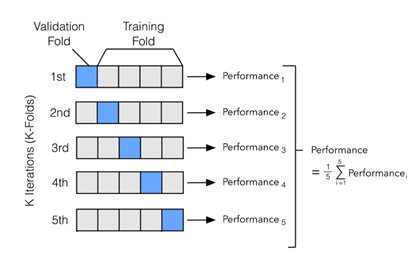

In [34]:
# 5.2 Cross validation strategy for the modeler
#      Perform startified k-fold cross-validation
#      There is also RepeatedStratifiedKFold() class
#      that will repeat startified k-fold N-number
#      of times
#      Instantiate cross-vlidation object
"""
Examples of Cross-validation strategies:
    i)   Leave one out  : Very time consuming
    ii)  Leave P out    : For example, leave 2 out
    iii) kfold          : k-equal random folds
    iv)  StratifiedKFold : kfolds + stratification
    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs
                          of (train,test). For examples, in each
                          (train,test) pair, let number of rows
                          of 'test' data be 30% of train data

"""

cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )

"\nExamples of Cross-validation strategies:\n    i)   Leave one out  : Very time consuming\n    ii)  Leave P out    : For example, leave 2 out\n    iii) kfold          : k-equal random folds\n    iv)  StratifiedKFold : kfolds + stratification\n    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs\n                          of (train,test). For examples, in each\n                          (train,test) pair, let number of rows\n                          of 'test' data be 30% of train data\n\n"

#### Bayes tuner object

In [43]:
# 5.3 Bayesian object instantiation
#     For API, refer: https://scikit-optimize.github.io/#skopt.BayesSearchCV
#     For example: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

start = time.time()
bayes_cv_tuner = BayesSearchCV(
                              estimator = pipe,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 10,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )
end = time.time()
(end-start)/60

2.368291219075521e-06

#### Begin tuning

In [44]:
# 5.4 Start learning using Bayes tuner

start = time.time()
result = bayes_cv_tuner.fit(
                            train_x,       # Note that we use normal train data
                            train_y,       #  rather than lgb train-data matrix
                            #callback=status_print
                           )

end = time.time()
(end - start)/60


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.6s finished


[LightGBM] [Warning] bagging_fraction is set=0.9234158717004632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234158717004632
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7994602362675662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7994602362675662
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9234158717004632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234158717004632
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7994602362675662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7994602362675662
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignor

0.5544545332590739

#### Results

In [ ]:
# 6.0 So what are the results?
#      Use the following estimator in future
#      What parameters the best estimator was using?

best_params = pd.Series(bayes_cv_tuner.best_params_)
print(best_params)

# 6.1 Best auc score for the above estimator

print("\n\nBest score: ", np.round(bayes_cv_tuner.best_score_, 4))


bagging_fraction        0.923416
bagging_freq                   8
boosting                    dart
feature_fraction         0.79946
learning_rate           0.153193
max_bin                      635
max_depth                     33
min_child_samples             22
min_child_weight         7.60494
n_estimators                  82
num_leaves                    42
reg_alpha            0.000833057
reg_lambda             0.0219248
scale_pos_weight         4.11378
subsample_for_bin         287406
dtype: object


Best score:  0.9803


In [ ]:
# 6.2 Summary of all models developed by Bayes process

allModels_summary = pd.DataFrame(bayes_cv_tuner.cv_results_)
allModels_summary.shape  # 50 X 26 ; 50 iterations

# 17.3
allModels_summary.head()

(10, 26)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_boosting,param_feature_fraction,param_learning_rate,param_max_bin,param_max_depth,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample_for_bin,params
0,0.976999,0.977463,0.974857,0.976440,0.001135,3,0.702537,0.311060,0.021811,0.006333,0.882021,8,gbdt,0.352640,0.218925,473,18,37,3.740170,82,27,1.385174e-08,1.370904e-07,6.688861,131156,"{'bagging_fraction': 0.8820207917706628, 'bagg..."
1,0.980483,0.980932,0.978493,0.979969,0.001060,2,5.272465,3.297048,0.038632,0.016431,0.967478,9,dart,0.860979,0.534879,156,8,18,6.721562,98,30,8.524050e-01,1.590337e+00,4.496724,342928,"{'bagging_fraction': 0.9674776711106569, 'bagg..."
2,0.945151,0.952531,0.936246,0.944643,0.006658,9,1.585780,0.729317,0.029046,0.011230,0.888967,9,dart,0.446666,0.023763,508,9,38,6.016064,99,33,2.711809e-06,2.367361e-07,5.585960,278139,"{'bagging_fraction': 0.8889665024602303, 'bagg..."
3,0.976621,0.976025,0.973043,0.975230,0.001565,4,0.739239,0.399895,0.022771,0.008165,0.962479,3,gbdt,0.742212,0.111200,186,38,44,9.207360,69,19,3.449623e-02,2.114410e-02,1.236578,485880,"{'bagging_fraction': 0.9624791976714727, 'bagg..."
4,0.974006,0.976800,0.970314,0.973707,0.002657,5,1.206950,0.558106,0.023425,0.007199,0.959911,5,gbdt,0.672571,0.642250,745,22,33,4.177755,83,26,8.740059e-02,1.165902e-06,3.383559,207155,"{'bagging_fraction': 0.9599106883214347, 'bagg..."


In [ ]:
####### I am done #############